# TSNE

In [11]:
%matplotlib inline
import random
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json

from sklearn.manifold import TSNE

In [19]:
data = {}
with open("resourceMIE_embeds_alltrain.json", "r+") as fin:
    data = json.load(fin)
emb = {}
for key in data.keys():
    emb[int(key)] = np.array(data[key])


In [20]:
with open("resource_List(1).csv", "r") as fin:
    resource_list = [x.strip() for x in fin.readlines()]
resource_list = resource_list[1:]
df=pd.DataFrame(resource_list)

In [21]:
# emb[1] = emb[3]
# random.shuffle(emb[1])
# emb[2] = emb[1]
# random.shuffle(emb[2])
# # df

In [25]:
# resource = "aws_iam_user"

# ridx = 0
# for i in range(0, len(resource_list)):
#     if resource==resource_list[i].strip():
#         ridx = i
# w = emb[ridx]

s_l = [] # score list of lists
for key in emb.keys():
    s_l.append(emb[key])
s_l = np.array(s_l)

# n, m, k = emb.shape

# tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
# # embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(remb.reshape(n * m, k))).reshape(n, m, 2)
p = 30
tsne = TSNE(random_state=1, n_iter=15000, metric="cosine", perplexity=p)
remb = tsne.fit_transform(s_l)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


In [26]:
df['x'] = remb[:, 0]
df['y'] = remb[:, 1]
embs = remb

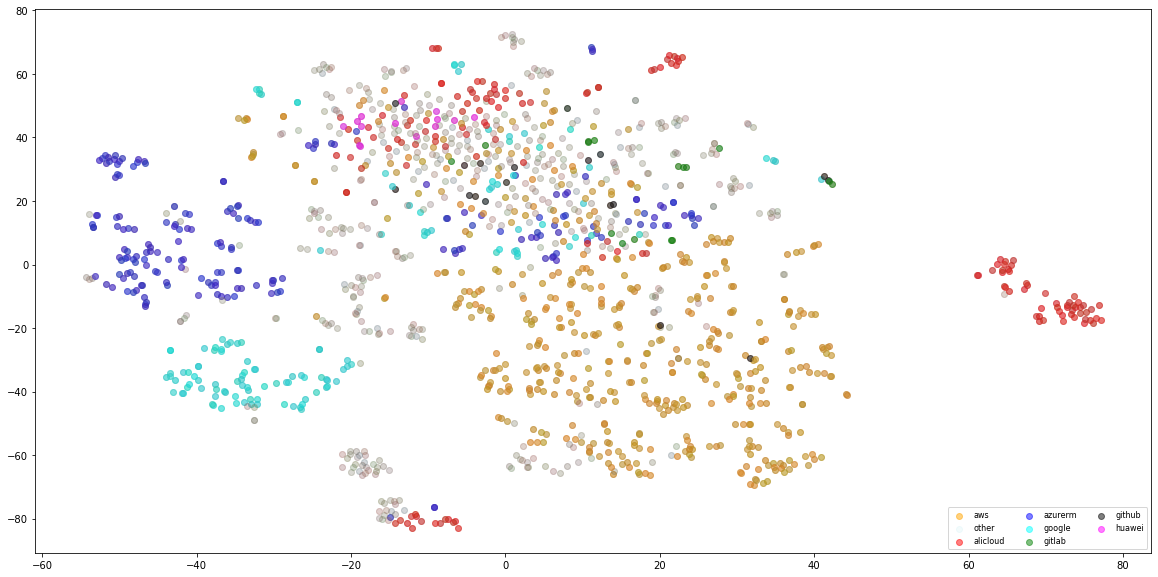

In [27]:
FS = (20, 10)
fig, ax = plt.subplots(figsize=FS)

resource = "aws_vpc_dhcp_options"
ridx = 0
for i in range(0, len(resource_list)):
    if resource==resource_list[i].strip():
        ridx = i

# Make points translucent so we can visually identify regions with a high density of overlapping points
# ax.scatter(df.x, df.y, alpha=0)

# aws yellow
# azure blue
# google red
colors = {
    "aws" : "orange",
    "azurerm": "blue",
    "alicloud": "red",
    "google": "cyan",
    "huawei": "magenta",
    "github": "black",
    "gitlab": "green"
    
}
plots = {}
for i, txt in enumerate(resource_list):
    for key in colors.keys():
        if key in txt:
            plots[key] = ax.scatter(df.x[i], df.y[i], color=colors[key], alpha=0.5)
        else:
            plots["other"] = ax.scatter(df.x[i], df.y[i], alpha=.05)

            
plt.legend((plots.values()),list(plots.keys()),scatterpoints=1,loc='lower right',ncol=3,fontsize=8)            
plt.savefig(f"ClusterfigsMIE/mie_p{p}.png")

In [ ]:
plt.c

In [126]:
# Some helper functions for plotting annotated t-SNE visualizations

# TODO: adjust_text not available in kernels
try:
    from adjustText import adjust_text
except ImportError:
    def adjust_text(*args, **kwargs):
        pass

def adjust_text(*args, **kwargs):
    pass

def plot_bg(bg_alpha=.01, figsize=(13, 9), emb_2d=None):
    """Create and return a plot of all our movie embeddings with very low opacity.
    (Intended to be used as a basis for further - more prominent - plotting of a 
    subset of movies. Having the overall shape of the map space in the background is
    useful for context.)
    """
    if emb_2d is None:
        emb_2d = embs
    fig, ax = plt.subplots(figsize=figsize)
    X = emb_2d[:, 0]
    Y = emb_2d[:, 1]
    ax.scatter(X, Y, alpha=bg_alpha)
    return ax

def annotate_sample(n, n_ratings_thresh=0):
    """Plot our embeddings with a random sample of n movies annotated.
    Only selects movies where the number of ratings is at least n_ratings_thresh.
    """
    sample = mainstream_movies[mainstream_movies.n_ratings >= n_ratings_thresh].sample(
        n, random_state=1)
    plot_with_annotations(sample.index)

def plot_by_title_pattern(pattern, **kwargs):
    """Plot all movies whose titles match the given regex pattern.
    """
    match = df[df.title.str.contains(pattern)]
    return plot_with_annotations(match.index, **kwargs)

def add_annotations(ax, label_indices, emb_2d=None, **kwargs):
    if emb_2d is None:
        emb_2d = embs
    X = emb_2d[label_indices, 0]
    Y = emb_2d[label_indices, 1]
    ax.scatter(X, Y, **kwargs)

def plot_with_annotations(label_indices, text=True, labels=None, alpha=1, **kwargs):
    ax = plot_bg(**kwargs)
    Xlabeled = embs[label_indices, 0]
    Ylabeled = embs[label_indices, 1]
    if labels is not None:
        for x, y, label in zip(Xlabeled, Ylabeled, labels):
            ax.scatter(x, y, alpha=alpha, label=label, marker='1',
                       s=90,
                      )
        fig.legend()
    else:
        ax.scatter(Xlabeled, Ylabeled, alpha=alpha, color='green')
    
    if text:
        # TODO: Add abbreviated title column
        titles = np.array(resource_list) # mainstream_movies.loc[label_indices, 'title'].values
        texts = []
        print(Xlabeled)
        for label, x, y in zip(titles, Xlabeled, Ylabeled):
            t = ax.annotate(label, xy=(x, y))
            texts.append(t)
        adjust_text(texts, 
                    #expand_text=(1.01, 1.05),
                    arrowprops=dict(arrowstyle='->', color='red'),
                   )
    return ax

FS = (13, 9)
def plot_region(x0, x1, y0, y1, text=True):
    """Plot the region of the mapping space bounded by the given x and y limits.
    """
    fig, ax = plt.subplots(figsize=FS)
    pts = df[
        (df.x >= x0) & (df.x <= x1)
        & (df.y >= y0) & (df.y <= y1)
    ]
    ax.scatter(pts.x, pts.y, alpha=.6)
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    if text:
        texts = []
        for label, x, y in zip(pts.title.values, pts.x.values, pts.y.values):
            t = ax.annotate(label, xy=(x, y))
            texts.append(t)
        adjust_text(texts, expand_text=(1.01, 1.05))
    return ax

def plot_region_around(title, margin=5, **kwargs):
    """Plot the region of the mapping space in the neighbourhood of the the movie with
    the given title. The margin parameter controls the size of the neighbourhood around
    the movie.
    """
    xmargin = ymargin = margin
    match = df[df.title == title]
    assert len(match) == 1
    row = match.iloc[0]
    return plot_region(row.x-xmargin, row.x+xmargin, row.y-ymargin, row.y+ymargin, **kwargs)

-27.002972


TypeError: zip argument #2 must support iteration

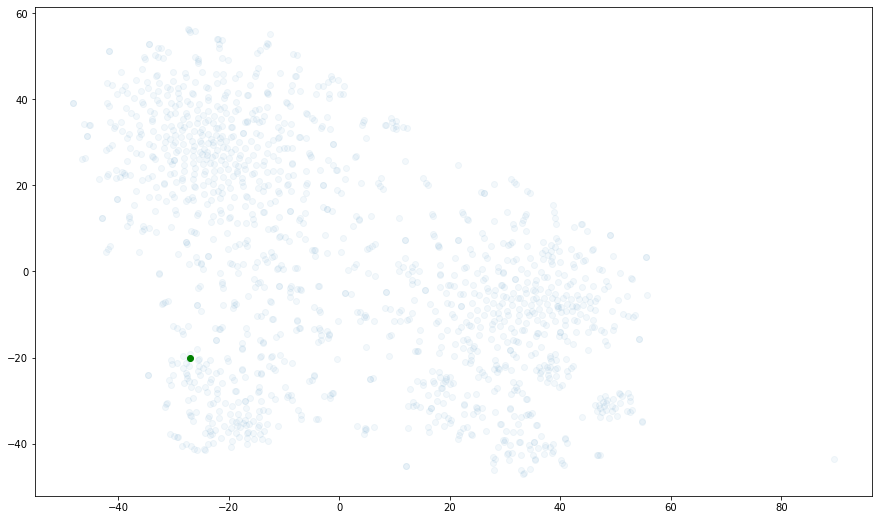

In [128]:
ridx = 0
for i in range(0, len(resource_list)):
    if resource==resource_list[i].strip():
        ridx = i


plot_with_annotations(ridx, figsize=(15, 9), bg_alpha=.05, text=True)
# plot_region_around('aws_autoscaling_schedule', 4);